In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf3
import odf
import h5py

In [3]:
def get_points_noRand(range_r, buffer = 1):
    # Punkte vordefinieren
    x = np.arange(-range_r, range_r+1, 1)
    y = np.copy(x)
    z = np.copy(x)
    # erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # Punkte außerhalb des Kegels filtern 
    mask = (x_grid**2 + y_grid**2 + z_grid**2 <= (range_r+buffer)**2) & (x_grid**2 + y_grid**2 + z_grid**2 >= (range_r-buffer)**2)
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    # x, y, z zusammenfassen
    Kugelschale = np.concatenate((x_mask[:,None], y_mask[:,None], z_mask[:,None]), axis=1)
    # Kugelkoordinaten Winkel bestimmen
    beta = np.arccos(Kugelschale[:,0]/range_r)
    if np.sum(np.isnan(beta)) > 0:
        print(f"Warning, {np.sum(np.isnan(beta))} nan entries in beta!!!")
    alpha = np.arctan2(Kugelschale[:,2],Kugelschale[:,1])+math.pi/2
    if np.sum(np.isnan(alpha)) > 0:
        print(f"Warning, {np.sum(np.isnan(alpha))} nan entries in alpha!!!")
    return(Kugelschale, alpha, beta)

def generate_dict_basis_new_noRand(range_r:int = 10, factor:int = 10, band: int = 10, buffer: int = 0.8):
    Kugelschale, alpha, beta = get_points_noRand(factor, buffer)
    temp_dict = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, koords_in_kegel_cache(range_r, alpha, beta))}
    temp_dict_basis = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, get_basis_xyz_new(*Kugelschale.T, band, factor))}
    return temp_dict, temp_dict_basis, alpha, beta

def Get_AODF_noRand(ODFs:np.ndarray, dict_res:dict, dict_basis:dict, factor:int, x_koord:int, y_koord:int, z_koord:int, alpha:np.ndarray, beta:np.ndarray, factor_amp:int = 1000, sigma:float=2):
    # # Winkel generieren
    # rng = np.random.default_rng(random.randint(100000,10000000000))
    # beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
    # alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

    # Punkte im Kegel mit Basisvektoren und Winkeln generieren
    result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha, beta, True)
    result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
    weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

    # Mit weights alle punkte im Kegel ablaufen
    AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)
    
    greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
    multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    bands = 10
    # odf3._get_bands_from_coeff(ODFs.shape[-1])
    nan_mask = ~np.isnan(multiple_inc)
    Test_mask = multiple_inc == 0
    if str(Test_mask[nan_mask].shape) == "(0,)":
        return np.empty((1,1,1,odf.get_num_coeff(bands)))
    AODF_d = odf.compute(np.ravel(multiple_dir[nan_mask])[None,None,None,:],np.ravel(multiple_inc[nan_mask])[None,None,None,:], np.ones(np.ravel(multiple_inc[nan_mask])[None,None,None,:].shape), bands)
    return AODF_d

(314, 3)

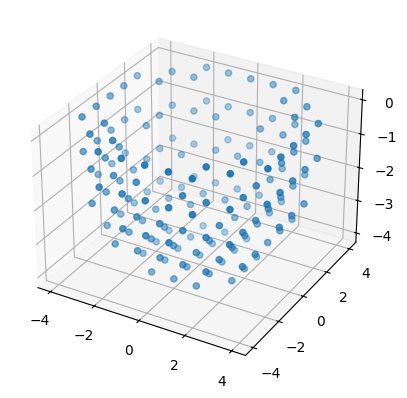

In [27]:
kugelschale= np.array(get_points(4,0.8)[0])
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
mask = kugelschale.T[2] <= 0 
kugel = kugelschale[mask,:]
ax.scatter(*kugel.T)
kugelschale.shape

In [4]:
def genereate_divergence():
    field_phi = np.empty((60,60,60))
    field_theta = np.copy(field_phi)
    for i in range(field_phi.shape[0]):
        for j in range(field_phi.shape[1]):
            for k in range(field_phi.shape[2]):
                field_phi[i,j,k] = 0 # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20])) # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20]))
                field_theta[i,j,k] = np.arctan2(j+10,i+10)
    return(field_theta, field_phi)

def genereate_swirls():
    field_phi = np.empty((60,60,60))
    field_theta = np.copy(field_phi)
    for i in range(field_phi.shape[0]):
        for j in range(field_phi.shape[1]):
            for k in range(field_phi.shape[2]):
                field_phi[i,j,k] = 0 # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20])) # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20]))
                field_theta[i,j,k] = np.pi * (i+j)*0.02
    return(field_theta, field_phi)

def get_Y_Odfs_noise(bands:int=10):
    Direction_zero = direction = np.random.uniform(0, 1, (40,40,40))*np.pi
    Inclination_zero = np.zeros((40,40,40))
    mask = np.ones((40,40,40))
    for i in range(Direction_zero.shape[0]):
        for j in range(Direction_zero.shape[1]):
            for k in range(Direction_zero.shape[2]):
                if j <= 25 and i <= 27 and i >= 23 and k <= 50:
                    Direction_zero[i,j,k] = np.pi*(1/2)
                elif i <= 50 and j <= 50 and k <= 50 and j <= -i+52 and j >= -i+48 and j > 25:
                    Direction_zero[i,j,k] = np.pi*(1-1/4)
                elif i <= 50 and j <= 50 and k <= 50 and j <= i+2 and j >= i-2 and j > 25:
                    Direction_zero[i,j,k] = np.pi*(1+1/4)
                # else:
                #     mask[i,j,k] = 0
    _ODFs = odf3.compute(Direction_zero[:,:,:,None], Inclination_zero[:,:,:,None], mask[:,:,:,None], bands)
    return _ODFs    

In [11]:
#field_theta, field_phi = genereate_divergence()
field_theta, field_phi = genereate_swirls()


In [21]:
ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)
# ODFs = get_Y_Odfs_noise(10)
np.array(ODFs).shape

(60, 60, 60, 66)

In [25]:
np.save("Konsistenz_check_ODFs", ODFs[range_r+1:20,range_r+1:20,range_r+1:20,:])

In [2]:
from main_lib import *
# Cache erstellen
factor = 7
range_r = 3
bands = 10
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=0.4)#load_dict(range_r, factor), load_dict(range_r, factor+1)
alpha.shape

(530,)

In [24]:
sigma = 0.1
factor_amp = 1000
limit_x, limit_y, limit_z = ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
bands = 10
AODFs = np.empty((limit_x-2*range_r,limit_y-2*range_r,limit_z-2*range_r,odf.get_num_coeff(bands)))
for i in range(range_r+1,limit_x-range_r-1):
    for j in range(range_r+1,limit_y-range_r-1):
        for k in range(range_r+1,limit_z-range_r-1):
            AODF_single = Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
            AODFs[i-range_r-1,j-range_r-1,k-range_r-1,:] = AODF_single[0,0,0,:]

np.save(f"Konsistenz_check_NoRand_0_f{factor}_n{number_of_winkel}", AODFs)
# 6_ODF_fastpli_factor{factor}_ranger{range_r}_sigma{sigma}_factoramp{factor_amp}_numerWinkel{number_of_winkel}_bands{odf.get_num_coeff(bands)}

In [138]:
range(range_r,limit-range_r), AODFs.shape, ODFs.shape

(range(3, 57), (54, 54, 54, 49), (60, 60, 60, 28))

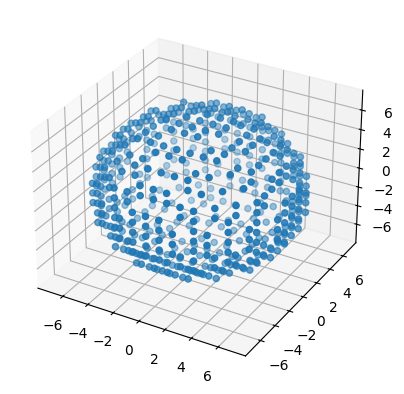

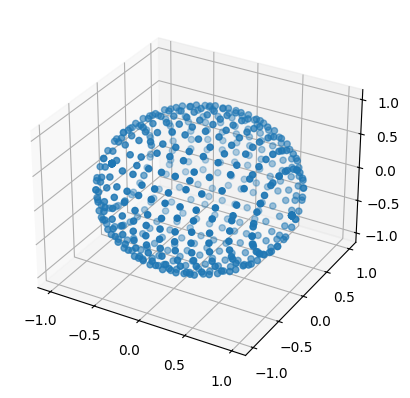

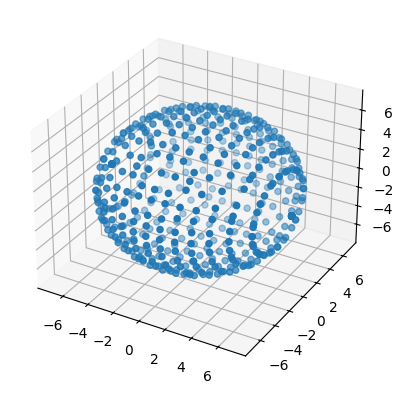

(530,)

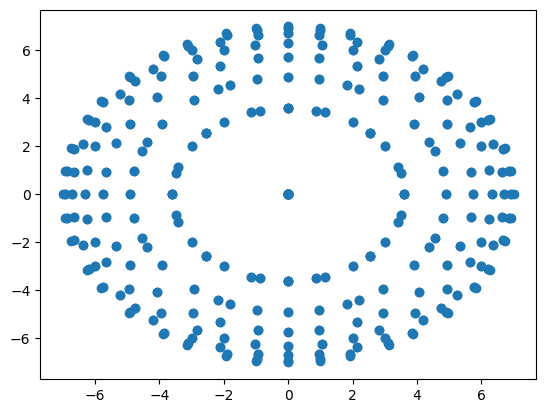

In [98]:
from main_lib import *
# Cache erstellen
factor = 7
range_r = 3
bands = 10
buffer = 0.4
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=buffer)#load_dict(range_r, factor), load_dict(range_r, factor+1)


kugelschale= np.array(get_points_noRand(factor,buffer)[0])
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*kugelschale.T)
plt.show()


cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x_ = (cos_beta)
y_ = (sin_alpha*sin_beta)
z_ = (-cos_alpha*sin_beta)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(x_,y_,z_)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(x_*factor,y_*factor,z_*factor)
plt.show()

plt.scatter(z_*factor,y_*factor)
alpha.shape

21

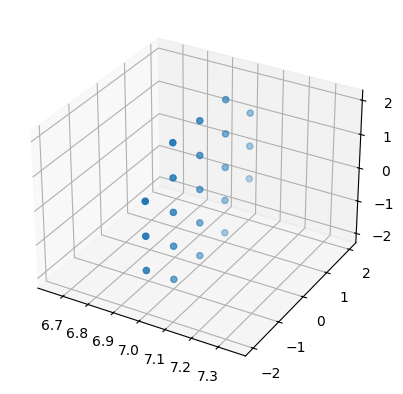

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [111]:
mask = kugelschale[:,0] >= 7

x_kugel = kugelschale[mask,0]
y_kugel = kugelschale[mask,1]
z_kugel = kugelschale[mask,2]

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(x_kugel, y_kugel, z_kugel)
plt.show()
x_kugel

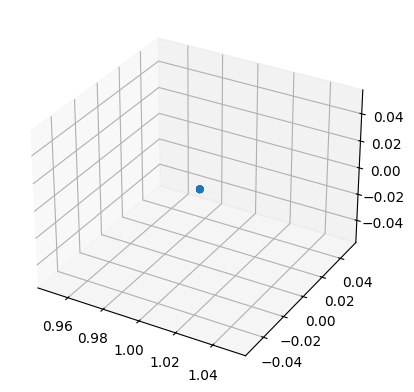

(array([-1.10714872,  4.71238898,  4.24874137, -0.46364761, -0.78539816,
         4.71238898,  3.92699082,  3.60524026,  0.        ,  0.        ,
         1.57079633,  3.14159265,  3.14159265,  0.46364761,  0.78539816,
         1.57079633,  2.35619449,  2.67794504,  1.10714872,  1.57079633,
         2.03444394]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]))

In [110]:
beta = np.arccos(x_kugel/factor)
alpha = np.arctan2(z_kugel,y_kugel)+math.pi/2

cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x_ = (cos_beta)
y_ = (sin_alpha*sin_beta)
z_ = (-cos_alpha*sin_beta)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(x_,y_,z_)
plt.show()

alpha, beta

C:\Users\tlock\AppData\Local\Temp\ipykernel_17848\1260267046.py:48: RuntimeWarning: invalid value encountered in divide
  WW = WW / np.amax( WW )


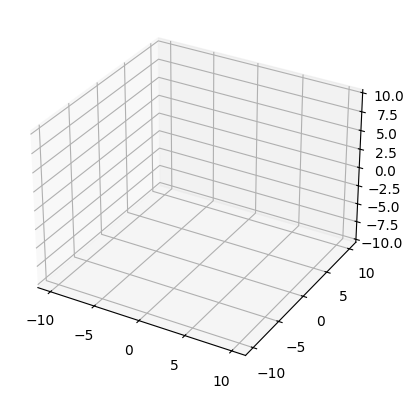

In [83]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=np.linalg.norm( p - pj )
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt



pointList = np.array([x_,y_,z_]).T


# def random_point( r=1 ):
#     ct = 2*np.random.rand() - 1
#     st = np.sqrt( 1 - ct**2 )
#     phi = 2* np.pi *  np.random.rand()
#     x = r * st * np.cos( phi)
#     y = r * st * np.sin( phi)
#     z = r * ct
#     return np.array( [x, y, z ] )

# pointList = np.array([ random_point( 10.05 ) for i in range( 65 ) ] )

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

u = np.linspace( 0, 2 * np.pi, 120 )
v = np.linspace( 0, np.pi, 60 )

# create the sphere surface
XX = 10 * np.outer( np.cos( u ), np.sin( v ) )
YY = 10 * np.outer( np.sin( u ), np.sin( v ) )
ZZ = 10 * np.outer( np.ones( np.size( u ) ), np.cos( v ) )

WW = XX.copy()
for i in range( len( XX ) ):
    for j in range( len( XX[0] ) ):
        x = XX[ i, j ]
        y = YY[ i, j ]
        z = ZZ[ i, j ]
        WW[ i, j ] = near(np.array( [x, y, z ] ), pointList, 3)
WW = WW / np.amax( WW )
myheatmap = WW

# ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
plt.show() 

In [50]:
pointList.shape

(65, 3)

In [52]:
pointList = np.array([x_,y_,z_])
pointList.shape

(3, 914)

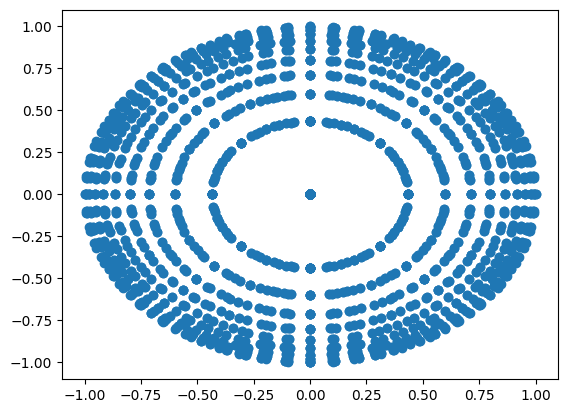

In [20]:
@njit(cache=True, parallel = True)
def get_amplitude(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # Koordinaten außerhalb der range von ODF filtern
        # print(mask_3d.shape)
        # mask_odf = ~((mask_3d[0]>=ODFs.shape[0]) | (mask_3d[0]<0) | (mask_3d[1]>=ODFs.shape[1]) | (mask_3d[1]<0) | (mask_3d[2]>=ODFs.shape[2]) | (mask_3d[2]<0))
        # # mask_odf = ((mask_3d[0]<ODFs.shape[0]) & (mask_3d[0]>0) & (mask_3d[1]<ODFs.shape[1]) & (mask_3d[1]>0) & (mask_3d[2]<ODFs.shape[2]) & (mask_3d[2]>0))
        # mask_3d = mask_3d[:,mask_odf]
        # nur weights auswählen die nicht nan inhalte haben
        if mask_3d.shape[-1] > 0:
            weight = weights[i, nan_mask[0]]
            # weight = weight[mask_odf]
            Test_ODF_masked = np.dot(weight[None,:], ODFs[mask_3d[0],mask_3d[1],mask_3d[2]])
            sum = np.dot(basis[None,i], Test_ODF_masked.T)
            AODF_Amplitude[i] = sum.item()/mask_3d.shape[-1]
        else:
            AODF_Amplitude[i] = int(0)
    return AODF_Amplitude

In [21]:
#field_theta, field_phi = genereate_divergence()
field_theta, field_phi = genereate_swirls()
ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)
# ODFs = get_Y_Odfs_noise(10)
np.array(ODFs).shape

(60, 60, 60, 66)

### ohne njit 

In [73]:
def get_amplitude(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # Koordinaten außerhalb der range von ODF filtern
        # print(mask_3d.shape)
        # mask_odf = ~((mask_3d[0]>=ODFs.shape[0]) | (mask_3d[0]<0) | (mask_3d[1]>=ODFs.shape[1]) | (mask_3d[1]<0) | (mask_3d[2]>=ODFs.shape[2]) | (mask_3d[2]<0))
        # # mask_odf = ((mask_3d[0]<ODFs.shape[0]) & (mask_3d[0]>0) & (mask_3d[1]<ODFs.shape[1]) & (mask_3d[1]>0) & (mask_3d[2]<ODFs.shape[2]) & (mask_3d[2]>0))
        # mask_3d = mask_3d[:,mask_odf]
        # nur weights auswählen die nicht nan inhalte haben
        if mask_3d.shape[-1] > 0:
            weight = weights[i, nan_mask[0]]
            # weight = weight[mask_odf]
            Test_ODF_masked = np.dot(weight[None,:], ODFs[mask_3d[0],mask_3d[1],mask_3d[2]])
            sum = np.dot(basis[None,i], Test_ODF_masked.T)
            AODF_Amplitude[i] = sum.item()/mask_3d.shape[-1]
        else:
            AODF_Amplitude[i] = int(0)
    return AODF_Amplitude

    
sigma = 0.1
factor_amp = 1000
limit_x, limit_y, limit_z = 20,20,20# ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
bands = 10
AODFs = np.empty((limit_x-2*range_r,limit_y-2*range_r,limit_z-2*range_r,odf.get_num_coeff(bands)))
AODFs = np.array([
    Get_AODF_noRand(ODFs, dict_res, dict_basis, factor, i, j, k, alpha=alpha[:, None], beta=beta[:, None], sigma=sigma, factor_amp=factor_amp)[0, 0, 0, :]
    for i in range(range_r + 1, limit_x - range_r - 1)
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])


# for i in range(range_r+1,limit_x-range_r-1):
#     for j in range(range_r+1,limit_y-range_r-1):
#         for k in range(range_r+1,limit_z-range_r-1):
#             AODF_single = Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
#             AODFs[i-range_r-1,j-range_r-1,k-range_r-1,:] = AODF_single[0,0,0,:]

# np.save(f"Konsistenz_check_NoRand_0_f{factor}", AODFs)
# 6_ODF_fastpli_factor{factor}_ranger{range_r}_sigma{sigma}_factoramp{factor_amp}_numerWinkel{number_of_winkel}_bands{odf.get_num_coeff(bands)}

### mit njit

In [19]:
@njit(cache=True)
def get_amplitude(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
    AODF_Amplitude = np.empty((result.shape[0]))
    for i, res in enumerate(result):
        # mask für nan werte
        nan_mask = ~np.isnan(res)
        mask = np.array(res[nan_mask], int)
        # shape anpassen
        mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
        # Koordinaten außerhalb der range von ODF filtern
        # print(mask_3d.shape)
        # mask_odf = ~((mask_3d[0]>=ODFs.shape[0]) | (mask_3d[0]<0) | (mask_3d[1]>=ODFs.shape[1]) | (mask_3d[1]<0) | (mask_3d[2]>=ODFs.shape[2]) | (mask_3d[2]<0))
        # # mask_odf = ((mask_3d[0]<ODFs.shape[0]) & (mask_3d[0]>0) & (mask_3d[1]<ODFs.shape[1]) & (mask_3d[1]>0) & (mask_3d[2]<ODFs.shape[2]) & (mask_3d[2]>0))
        # mask_3d = mask_3d[:,mask_odf]
        # nur weights auswählen die nicht nan inhalte haben
        if mask_3d.shape[-1] > 0:
            weight = weights[i, nan_mask[0]]
            # weight = weight[mask_odf]
            Test_ODF_masked = np.dot(weight[None,:], ODFs[mask_3d[0],mask_3d[1],mask_3d[2]])
            sum = np.dot(basis[None,i], Test_ODF_masked.T)
            AODF_Amplitude[i] = sum.item()/mask_3d.shape[-1]
        else:
            AODF_Amplitude[i] = int(0)
    return AODF_Amplitude
sigma = 0.1
factor_amp = 1000
limit_x, limit_y, limit_z = 30,30,30# ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
bands = 10
AODFs = np.empty((limit_x-2*range_r,limit_y-2*range_r,limit_z-2*range_r,odf.get_num_coeff(bands)))
for i in range(range_r+1,limit_x-range_r-1):
    for j in range(range_r+1,limit_y-range_r-1):
        for k in range(range_r+1,limit_z-range_r-1):
            AODF_single = Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
            AODFs[i-range_r-1,j-range_r-1,k-range_r-1,:] = AODF_single[0,0,0,:]

# np.save(f"Konsistenz_check_NoRand_0_f{factor}", AODFs)
# 6_ODF_fastpli_factor{factor}_ranger{range_r}_sigma{sigma}_factoramp{factor_amp}_numerWinkel{number_of_winkel}_bands{odf.get_num_coeff(bands)}

### mit njit paralell True

In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf3
import odf
import h5py

def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Translation Rückgängig machen
    data_ = np.copy(data)
    data_[:,0,:] -= x_koord
    data_[:,1,:] -= y_koord
    data_[:,2,:] -= z_koord
    # Für Optimierung Variablen vor definieren
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix = np.empty((len(alpha), 3, 3))
    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    # Wende die Rotationsmatrix auf die Daten an
    result = np.matmul(rotation_matrix, data_)
    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    return result

def kegel_from_dict_withBasis(dict_cache:dict, dict_cache_basis:dict, factor:int=10, x_koord:int=0, y_koord:int=0, z_koord:int=0, alpha:np.ndarray=np.array([]), beta:np.ndarray=np.array([]), get_phi_theta = False):
    # Winkelfunktionen vordefinieren
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    koords = np.concatenate((x,y,z), axis=1)
    koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
    # Daten aus dem Dict herausholen
    arrays = [dict_cache[tuple(key)] for key in koords_rounded_int]
    result = np.array(arrays)
    arrays_basis = [dict_cache_basis[tuple(key)] for key in koords_rounded_int]
    res_basis = np.array(arrays_basis)
    # else:  # langsamer
    #     result = np.array(Parallel(n_jobs=-1)(delayed(get_array)(dict_cache,key) for key in koords_rounded_int))

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    if get_phi_theta == True:
        # Phi und Theta berechnen für ODFs
        phi = np.arccos(z)
        theta = np.arctan2(y,x)
        return (result, res_basis, phi, theta)

    return result, res_basis

def koords_in_kegel_cache(range_r = 4, alpha = np.array([]), beta = np.array([])):
    # Winkel umdrehen, da Koordinatensystem gedreht wird anstatt der Punkte
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    cos_alpha_cos_beta = cos_alpha*cos_beta
    sin_alpha_cos_beta = sin_alpha*cos_beta
    cos_alpha_sin_beta = cos_alpha*sin_beta
    sin_alpha_sin_beta = sin_alpha*sin_beta
    
    # erstelle das Gitter für x, y und z
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)
    length = int(((2*range_r)**3)/6)+1

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # test_x = np.copy(x_grid)
    result = np.empty((len(cos_alpha), 3, length)) * np.nan

    for i, ca, sa, cb, sb, cacb, sacb, casb, sasb in zip(range(len(cos_alpha)), cos_alpha, sin_alpha, cos_beta, sin_beta, cos_alpha_cos_beta, sin_alpha_cos_beta, cos_alpha_sin_beta, sin_alpha_sin_beta):
        # erst x achse dann y achse
        mask = (((ca*y_grid-sa*z_grid)**2 + (cacb*z_grid-sb*x_grid+sacb*y_grid)**2 < (casb*z_grid+sasb*y_grid+cb*x_grid)**2) & (0 < (casb*z_grid+sasb*y_grid+cb*x_grid)) & (range_r > (casb*z_grid+sasb*y_grid+cb*x_grid)))
        # x,y,z werte mit der spezifischen Maske auf die Kegel zuschneiden
        x_mask = x_grid[mask]
        y_mask = y_grid[mask]
        z_mask = z_grid[mask]
        data = np.array([x_mask, y_mask, z_mask])
        result[i,:,:np.shape(data)[1]] = data
    return result

def get_basis_xyz_new(x:int, y:int, z:int, band:int=10, factor:int=10):
    phi = np.arccos(z/factor)
    theta = np.arctan2(y,x)
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    basis = np.empty((phi.shape[0], odf3.get_num_coeff(band)))
    for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
        basis[i, :] = odf3._analytic_single_odf(ct, st, p, band)
    return basis

def get_points_noRand(range_r, buffer = 1):
    # Punkte vordefinieren
    x = np.arange(-range_r, range_r+1, 1)
    y = np.copy(x)
    z = np.copy(x)
    # erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # Punkte außerhalb des Kegels filtern 
    mask = (x_grid**2 + y_grid**2 + z_grid**2 <= (range_r+buffer)**2) & (x_grid**2 + y_grid**2 + z_grid**2 >= (range_r-buffer)**2)
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    # x, y, z zusammenfassen
    Kugelschale = np.concatenate((x_mask[:,None], y_mask[:,None], z_mask[:,None]), axis=1)
    # Kugelkoordinaten Winkel bestimmen
    beta = np.arccos(Kugelschale[:,0]/range_r)
    if np.sum(np.isnan(beta)) > 0:
        print(f"Warning, {np.sum(np.isnan(beta))} nan entries in beta!!!")
    alpha = np.arctan2(Kugelschale[:,2],Kugelschale[:,1])+math.pi/2
    if np.sum(np.isnan(alpha)) > 0:
        print(f"Warning, {np.sum(np.isnan(alpha))} nan entries in alpha!!!")
    return(Kugelschale, alpha, beta)

def generate_dict_basis_new_noRand(range_r:int = 10, factor:int = 10, band: int = 10, buffer: int = 0.8):
    Kugelschale, alpha, beta = get_points_noRand(factor, buffer)
    temp_dict = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, koords_in_kegel_cache(range_r, alpha, beta))}
    temp_dict_basis = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, get_basis_xyz_new(*Kugelschale.T, band, factor))}
    return temp_dict, temp_dict_basis, alpha, beta

def Get_AODF_noRand(ODFs:np.ndarray, dict_res:dict, dict_basis:dict, factor:int, x_koord:int, y_koord:int, z_koord:int, alpha:np.ndarray, beta:np.ndarray, factor_amp:int = 1000, sigma:float=2):
    # # Winkel generieren
    # rng = np.random.default_rng(random.randint(100000,10000000000))
    # beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
    # alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

    # Punkte im Kegel mit Basisvektoren und Winkeln generieren
    result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha, beta, True)
    result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
    weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

    # Mit weights alle punkte im Kegel ablaufen
    AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)
    
    greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
    multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    bands = 10
    # odf3._get_bands_from_coeff(ODFs.shape[-1])
    nan_mask = ~np.isnan(multiple_inc)
    Test_mask = multiple_inc == 0
    if str(Test_mask[nan_mask].shape) == "(0,)":
        return np.empty((1,1,1,odf.get_num_coeff(bands)))
    AODF_d = odf.compute(np.ravel(multiple_dir[nan_mask]),np.ravel(multiple_inc[nan_mask]), np.ones(np.ravel(multiple_inc[nan_mask]).shape), bands)
    return AODF_d



# from numba import njit, prange

# @jit(nopython=False ,cache=True, parallel = True)
# def get_amplitude(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
#     AODF_Amplitude = np.empty((result.shape[0]))
#     for i in prange(result.shape[0]):
#         # mask für nan werte
#         nan_mask = ~np.isnan(result[i])
#         mask = np.array(result[i,nan_mask], int)
#         # shape anpassen
#         mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
#         # Koordinaten außerhalb der range von ODF filtern
#         # print(mask_3d.shape)
#         # mask_odf = ~((mask_3d[0]>=ODFs.shape[0]) | (mask_3d[0]<0) | (mask_3d[1]>=ODFs.shape[1]) | (mask_3d[1]<0) | (mask_3d[2]>=ODFs.shape[2]) | (mask_3d[2]<0))
#         # # mask_odf = ((mask_3d[0]<ODFs.shape[0]) & (mask_3d[0]>0) & (mask_3d[1]<ODFs.shape[1]) & (mask_3d[1]>0) & (mask_3d[2]<ODFs.shape[2]) & (mask_3d[2]>0))
#         # mask_3d = mask_3d[:,mask_odf]
#         # nur weights auswählen die nicht nan inhalte haben
#         if mask_3d.shape[-1] > 0:
#             weight = weights[i, nan_mask[0]]
#             # weight = weight[mask_odf]
#             Test_ODF_masked = np.dot(weight[None,:], ODFs[mask_3d[0],mask_3d[1],mask_3d[2]])
#             sum = np.dot(basis[None,i], Test_ODF_masked.T)
#             AODF_Amplitude[i] = sum.item()/mask_3d.shape[-1]
#         else:
#             AODF_Amplitude[i] = int(0)   
#     return AODF_Amplitude

# def get_amplitude(result: np.ndarray, ODFs: np.ndarray, basis: np.ndarray, weights: np.ndarray) -> np.ndarray:
#     AODF_Amplitude = np.empty(result.shape[0])
#     for i in prange(result.shape[0]):
#         nan_mask = ~np.isnan(result[i])
#         mask = np.array(result[i, nan_mask], int).reshape(3, -1)
        
#         if mask.shape[-1] > 0:
#             weight = weights[i, nan_mask[0]]
#             Test_ODF_masked = np.dot(weight[None, :], ODFs[mask[0], mask[1], mask[2]])
#             AODF_Amplitude[i] = np.dot(basis[None, i], Test_ODF_masked.T).item() / mask.shape[-1]
#         else:
#             AODF_Amplitude[i] = 0
            
#     return AODF_Amplitude


def get_amplitude(result: np.ndarray, ODFs: np.ndarray, basis: np.ndarray, weights: np.ndarray) -> np.ndarray:
    return np.array([
        (
            np.dot(
                basis[None, i],
                np.dot(
                    weights[i, ~np.isnan(res)[0]][None, :],
                    ODFs[
                        tuple(np.reshape(np.array(res[~np.isnan(res)], int), (3, -1)))
                    ]
                ).T
            ).item() / np.reshape(np.array(res[~np.isnan(res)], int), (3, -1)).shape[-1]
        ) if np.reshape(np.array(res[~np.isnan(res)], int), (3, -1)).shape[-1] > 0
        else 0
        for i, res in enumerate(result)
    ])

                    # ODFs[
                    #     np.reshape(np.array(res[~np.isnan(res)], int), (3, -1))
                    # ]   


def genereate_swirls():
    field_phi = np.empty((60,60,60))
    field_theta = np.copy(field_phi)
    for i in range(field_phi.shape[0]):
        for j in range(field_phi.shape[1]):
            for k in range(field_phi.shape[2]):
                field_phi[i,j,k] = 0 # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20])) # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20]))
                field_theta[i,j,k] = np.pi * (i+j)*0.02
    return(field_theta, field_phi)


def gauss_2d(x,y,mu_x=0,mu_y=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2))

In [2]:
# Cache erstellen
factor = 7
range_r = 3
bands = 10
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=0.4)#load_dict(range_r, factor), load_dict(range_r, factor+1)
alpha.shape
#field_theta, field_phi = genereate_divergence()
field_theta, field_phi = genereate_swirls()
ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)
# ODFs = get_Y_Odfs_noise(10)
np.array(ODFs).shape

(60, 60, 60, 66)

In [3]:
ODFs[0][0].shape

(60, 66)

In [4]:
sigma = 0.1
factor_amp = 1000
limit_x, limit_y, limit_z = 20,20,20# ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
bands = 10
AODFs = np.empty((limit_x-2*range_r,limit_y-2*range_r,limit_z-2*range_r,odf.get_num_coeff(bands)))
for i in range(range_r+1,limit_x-range_r-1):
    for j in range(range_r+1,limit_y-range_r-1):
        for k in range(range_r+1,limit_z-range_r-1):
            AODF_single = Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
            AODFs[i-range_r-1,j-range_r-1,k-range_r-1,:] = AODF_single[0,0,0,:]

# np.save(f"Konsistenz_check_NoRand_0_f{factor}", AODFs)
# 6_ODF_fastpli_factor{factor}_ranger{range_r}_sigma{sigma}_factoramp{factor_amp}_numerWinkel{number_of_winkel}_bands{odf.get_num_coeff(bands)}

In [12]:
AODFs = np.array([
    Get_AODF_noRand(ODFs, dict_res, dict_basis, factor, i, j, k, alpha=alpha[:, None], beta=beta[:, None], sigma=sigma, factor_amp=factor_amp)[0, 0, 0, :]
    for i in np.arange(range_r + 1, limit_x - range_r - 1)
    for j in np.arange(range_r + 1, limit_y - range_r - 1)
    for k in np.arange(range_r + 1, limit_z - range_r - 1)
])


In [13]:
AODFs = np.array([
    Get_AODF_noRand(ODFs, dict_res, dict_basis, factor, i, j, k, alpha=alpha[:, None], beta=beta[:, None], sigma=sigma, factor_amp=factor_amp)[0, 0, 0, :]
    for i in range(range_r + 1, limit_x - range_r - 1)
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

In [78]:
from concurrent.futures import ThreadPoolExecutor
num_components = odf.get_num_coeff(bands)
def parallel_compute_AODFs(ODFs, dict_res, dict_basis, factor, alpha, beta, sigma, factor_amp, i, j, k):
    local_ODFs = np.copy(ODFs)  # Kopie von ODFs für jeden Thread
    local_dict_res = np.copy(dict_res)
    local_dict_basis = np.copy(dict_basis)
    local_factor = np.copy(factor)
    local_alpha = np.copy(alpha)
    local_beta = np.copy(beta)
    local_sigma = np.copy(sigma)
    local_factor_amp = np.copy(factor_amp)
    local_i = np.copy(i)
    local_j = np.copy(j)
    local_k = np.copy(k)
    AODF_single = Get_AODF_noRand(local_ODFs, local_dict_res, local_dict_basis, local_factor, local_i, local_j, local_k, alpha=local_alpha[:, None], beta=local_beta[:, None], sigma=local_sigma, factor_amp=local_factor_amp)
    return i - range_r - 1, j - range_r - 1, k - range_r - 1, AODF_single[0, 0, 0, :]

# Set the number of threads according to your needs
num_threads = 4

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    AODFs_list = list(executor.map(
        lambda args: parallel_compute_AODFs(ODFs, dict_res, dict_basis, factor, alpha, beta, sigma, factor_amp, *args),
        [(i, j, k) for i in range(range_r + 1, limit_x - range_r - 1) for j in range(range_r + 1, limit_y - range_r - 1) for k in range(range_r + 1, limit_z - range_r - 1)]
    ))

# Convert the list to a numpy array
AODFs = np.zeros((limit_x - range_r - 1, limit_y - range_r - 1, limit_z - range_r - 1, num_components))
for i, j, k, AODF_single in AODFs_list:
    AODFs[i, j, k, :] = AODF_single


IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed

In [11]:
from concurrent.futures import ThreadPoolExecutor
import copy
num_components = odf.get_num_coeff(bands)
def parallel_compute_AODFs(ODFs, dict_res, dict_basis, factor, alpha, beta, sigma, factor_amp, i, j, k):
    local_ODFs = copy.deepcopy(ODFs)
    local_dict_res = copy.deepcopy(dict_res)
    local_dict_basis = copy.deepcopy(dict_basis)
    local_factor = copy.deepcopy(factor)
    local_alpha = copy.deepcopy(alpha)
    local_beta = copy.deepcopy(beta)
    local_sigma = copy.deepcopy(sigma)
    local_factor_amp = copy.deepcopy(factor_amp)

    AODF_single = Get_AODF_noRand(local_ODFs, local_dict_res, local_dict_basis, local_factor, i, j, k, alpha=local_alpha[:, None], beta=local_beta[:, None], sigma=local_sigma, factor_amp=local_factor_amp)
    
    return i - range_r - 1, j - range_r - 1, k - range_r - 1, AODF_single[0, 0, 0, :]

# Set the number of threads according to your needs
num_threads = 12

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    AODFs_list = list(executor.map(
        lambda args: parallel_compute_AODFs(ODFs, dict_res, dict_basis, factor, alpha, beta, sigma, factor_amp, *args),
        [(i, j, k) for i in range(range_r + 1, limit_x - range_r - 1) for j in range(range_r + 1, limit_y - range_r - 1) for k in range(range_r + 1, limit_z - range_r - 1)]
    ))

# Convert the list to a numpy array
AODFs = np.zeros((limit_x - range_r - 1, limit_y - range_r - 1, limit_z - range_r - 1, num_components))
for i, j, k, AODF_single in AODFs_list:
    AODFs[i, j, k, :] = AODF_single


ValueError: could not broadcast input array from shape (121,) into shape (66,)

In [10]:
from concurrent.futures import ProcessPoolExecutor

def parallel_compute_AODFs(args):
    ODFs, dict_res, dict_basis, factor, alpha, beta, sigma, factor_amp, i, j, k = args
    local_ODFs = np.copy(ODFs)
    local_dict_res = dict_res.copy()
    local_dict_basis = dict_basis.copy()
    local_factor = factor.copy()
    local_alpha = alpha.copy()
    local_beta = beta.copy()
    local_sigma = sigma.copy()
    local_factor_amp = factor_amp.copy()

    AODF_single = Get_AODF_noRand(local_ODFs, local_dict_res, local_dict_basis, local_factor, i, j, k, alpha=local_alpha[:, None], beta=local_beta[:, None], sigma=local_sigma, factor_amp=local_factor_amp)
    
    return AODF_single[0, 0, 0, :]

# Set the number of processes according to your needs
num_processes = 4

with ProcessPoolExecutor(max_workers=num_processes) as executor:
    AODFs_list = np.array(list(executor.map(
        parallel_compute_AODFs,
        [(ODFs, dict_res, dict_basis, factor, alpha, beta, sigma, factor_amp, i, j, k) for i in range(range_r + 1, limit_x - range_r - 1) for j in range(range_r + 1, limit_y - range_r - 1) for k in range(range_r + 1, limit_z - range_r - 1)]
    )))

# Reshape the array to match the desired shape
AODFs = AODFs_list.reshape((limit_x - range_r - 1, limit_y - range_r - 1, limit_z - range_r - 1, num_components))


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [24]:
x_koord, y_koord, z_koord = 10,10,10

result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha[:,None], beta[:,None], True)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

# Mit weights alle punkte im Kegel ablaufen
AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)

greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
bands = 10
# odf3._get_bands_from_coeff(ODFs.shape[-1])
nan_mask = ~np.isnan(multiple_inc)
Test_mask = multiple_inc == 0

direction = np.ravel(multiple_dir[nan_mask])
inclination = np.ravel(multiple_inc[nan_mask])
mask = np.ones(np.ravel(multiple_inc[nan_mask]).shape)

ndim = direction.ndim
direction = np.array(direction, copy=False)
inclination = np.array(inclination, copy=False)
assert direction.shape == inclination.shape

if mask is None:
    mask = np.ones_like(direction, dtype=bool)
else:
    mask = np.array(mask, copy=False, dtype=bool)
    assert mask.shape == direction.shape

direction_ = direction.reshape((-1, direction.shape[-1]))
inclination_ = inclination.reshape((-1, inclination.shape[-1]))
mask_ = mask.reshape((-1, mask.shape[-1]))

results = odf._compute_flatten_array(direction_, inclination_, mask_, bands)

AODF = odf._compute_flatten_array(np.ravel(multiple_dir[nan_mask]),np.ravel(multiple_inc[nan_mask]), np.ones(np.ravel(multiple_inc[nan_mask]).shape), bands)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float64, 1d, C), Tuple(int64, slice<a:b>))
 
There are 22 candidate implementations:
[1m      - Of which 20 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 1d, C), Tuple(int64, slice<a:b>))':[0m
[1m       No match.[0m
[1m      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba\core\typing\arraydecl.py: Line 209.
        With argument(s): '(array(float64, 1d, C), Tuple(int64, slice<a:b>))':[0m
[1m       Rejected as the implementation raised a specific error:
         NumbaTypeError: [1mcannot index array(float64, 1d, C) with 2 indices: Tuple(int64, slice<a:b>)[0m[0m
  raised from C:\Users\tlock\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\typing\arraydecl.py:131
[0m
[0m[1mDuring: typing of intrinsic-call at d:\dokumente\Python Skripts\Bachelor\BA\odf.py (123)[0m
[1m
File "odf.py", line 123:[0m
[1mdef _compute_flatten_array(
    <source elided>
        coeff[i, :] = _compute_coefficients(
[1m            direction[i, :], inclination[i, :], mask[i, :], bands
[0m            [1m^[0m[0m


In [25]:
x_koord, y_koord, z_koord = 10,10,10

result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha[:,None], beta[:,None], True)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

# Mit weights alle punkte im Kegel ablaufen
AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)

greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
bands = 10
# odf3._get_bands_from_coeff(ODFs.shape[-1])
nan_mask = ~np.isnan(multiple_inc),
AODF_d = odf.compute(np.ravel(multiple_dir[nan_mask]),np.ravel(multiple_inc[nan_mask]), np.ones(np.ravel(multiple_inc[nan_mask]).shape), bands)

In [26]:
AODF_d.shape

(121,)

In [ ]:
sigma = 0.1
factor_amp = 1000
limit_x, limit_y, limit_z = 20,20,20# ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
bands = 10
AODFs = np.empty((limit_x-2*range_r,limit_y-2*range_r,limit_z-2*range_r,odf.get_num_coeff(bands)))
for i in range(range_r+1,limit_x-range_r-1):
    for j in range(range_r+1,limit_y-range_r-1):
        for k in range(range_r+1,limit_z-range_r-1):
            AODFs[i-range_r-1,j-range_r-1,k-range_r-1,:] = Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)

In [28]:
AODFs = np.array([
    Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
    for i in range(range_r + 1, limit_x - range_r - 1)
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

# Wo dauert die Funktion am lägsten?

In [ ]:
AODFs = np.array([
    Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
    for i in range(range_r + 1, limit_x - range_r - 1)
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from colour import Color
from collections import Counter
import random
from time import gmtime, strftime
from numba import jit, njit
import pickle 
import odf3
import odf
import h5py

def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Translation Rückgängig machen
    data_ = np.copy(data)
    data_[:,0,:] -= x_koord
    data_[:,1,:] -= y_koord
    data_[:,2,:] -= z_koord
    # Für Optimierung Variablen vor definieren
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix = np.empty((len(alpha), 3, 3))
    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    # Wende die Rotationsmatrix auf die Daten an
    result = np.matmul(rotation_matrix, data_)
    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    return result

def kegel_from_dict_withBasis(dict_cache:dict, dict_cache_basis:dict, factor:int=10, x_koord:int=0, y_koord:int=0, z_koord:int=0, alpha:np.ndarray=np.array([]), beta:np.ndarray=np.array([]), get_phi_theta = False):
    # Winkelfunktionen vordefinieren
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    koords = np.concatenate((x,y,z), axis=1)
    koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
    # Daten aus dem Dict herausholen
    arrays = [dict_cache[tuple(key)] for key in koords_rounded_int]
    result = np.array(arrays)
    arrays_basis = [dict_cache_basis[tuple(key)] for key in koords_rounded_int]
    res_basis = np.array(arrays_basis)
    # else:  # langsamer
    #     result = np.array(Parallel(n_jobs=-1)(delayed(get_array)(dict_cache,key) for key in koords_rounded_int))

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord
    if get_phi_theta == True:
        # Phi und Theta berechnen für ODFs
        phi = np.arccos(z)
        theta = np.arctan2(y,x)
        return (result, res_basis, phi, theta)

    return result, res_basis

def koords_in_kegel_cache(range_r = 4, alpha = np.array([]), beta = np.array([])):
    # Winkel umdrehen, da Koordinatensystem gedreht wird anstatt der Punkte
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    cos_alpha_cos_beta = cos_alpha*cos_beta
    sin_alpha_cos_beta = sin_alpha*cos_beta
    cos_alpha_sin_beta = cos_alpha*sin_beta
    sin_alpha_sin_beta = sin_alpha*sin_beta
    
    # erstelle das Gitter für x, y und z
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)
    length = int(((2*range_r)**3)/6)+1

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # test_x = np.copy(x_grid)
    result = np.empty((len(cos_alpha), 3, length)) * np.nan

    for i, ca, sa, cb, sb, cacb, sacb, casb, sasb in zip(range(len(cos_alpha)), cos_alpha, sin_alpha, cos_beta, sin_beta, cos_alpha_cos_beta, sin_alpha_cos_beta, cos_alpha_sin_beta, sin_alpha_sin_beta):
        # erst x achse dann y achse
        mask = (((ca*y_grid-sa*z_grid)**2 + (cacb*z_grid-sb*x_grid+sacb*y_grid)**2 < (casb*z_grid+sasb*y_grid+cb*x_grid)**2) & (0 < (casb*z_grid+sasb*y_grid+cb*x_grid)) & (range_r > (casb*z_grid+sasb*y_grid+cb*x_grid)))
        # x,y,z werte mit der spezifischen Maske auf die Kegel zuschneiden
        x_mask = x_grid[mask]
        y_mask = y_grid[mask]
        z_mask = z_grid[mask]
        data = np.array([x_mask, y_mask, z_mask])
        result[i,:,:np.shape(data)[1]] = data
    return result

def get_basis_xyz_new(x:int, y:int, z:int, band:int=10, factor:int=10):
    phi = np.arccos(z/factor)
    theta = np.arctan2(y,x)
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    basis = np.empty((phi.shape[0], odf3.get_num_coeff(band)))
    for i, (p, ct, st) in enumerate(zip(phi, costheta, sintheta)):
        basis[i, :] = odf3._analytic_single_odf(ct, st, p, band)
    return basis

def get_points_noRand(range_r, buffer = 1):
    # Punkte vordefinieren
    x = np.arange(-range_r, range_r+1, 1)
    y = np.copy(x)
    z = np.copy(x)
    # erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # Punkte außerhalb des Kegels filtern 
    mask = (x_grid**2 + y_grid**2 + z_grid**2 <= (range_r+buffer)**2) & (x_grid**2 + y_grid**2 + z_grid**2 >= (range_r-buffer)**2)
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    # x, y, z zusammenfassen
    Kugelschale = np.concatenate((x_mask[:,None], y_mask[:,None], z_mask[:,None]), axis=1)
    # Kugelkoordinaten Winkel bestimmen
    beta = np.arccos(Kugelschale[:,0]/range_r)
    if np.sum(np.isnan(beta)) > 0:
        print(f"Warning, {np.sum(np.isnan(beta))} nan entries in beta!!!")
    alpha = np.arctan2(Kugelschale[:,2],Kugelschale[:,1])+math.pi/2
    if np.sum(np.isnan(alpha)) > 0:
        print(f"Warning, {np.sum(np.isnan(alpha))} nan entries in alpha!!!")
    return(Kugelschale, alpha, beta)

def generate_dict_basis_new_noRand(range_r:int = 10, factor:int = 10, band: int = 10, buffer: int = 0.8):
    Kugelschale, alpha, beta = get_points_noRand(factor, buffer)
    temp_dict = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, koords_in_kegel_cache(range_r, alpha, beta))}
    temp_dict_basis = {tuple(a_row): b_row for a_row, b_row in zip(Kugelschale, get_basis_xyz_new(*Kugelschale.T, band, factor))}
    return temp_dict, temp_dict_basis, alpha, beta

def Get_AODF_noRand(ODFs:np.ndarray, dict_res:dict, dict_basis:dict, factor:int, x_koord:int, y_koord:int, z_koord:int, alpha:np.ndarray, beta:np.ndarray, factor_amp:int = 1000, sigma:float=2):
    # # Winkel generieren
    # rng = np.random.default_rng(random.randint(100000,10000000000))
    # beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
    # alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

    # Punkte im Kegel mit Basisvektoren und Winkeln generieren
    result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha, beta, True)
    result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
    weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

    # Mit weights alle punkte im Kegel ablaufen
    AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)
    
    greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
    multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    bands = 10
    # odf3._get_bands_from_coeff(ODFs.shape[-1])
    nan_mask = ~np.isnan(multiple_inc)
    Test_mask = multiple_inc == 0
    if str(Test_mask[nan_mask].shape) == "(0,)":
        return np.empty((1,1,1,odf.get_num_coeff(bands)))
    AODF_d = odf.compute(np.ravel(multiple_dir[nan_mask]),np.ravel(multiple_inc[nan_mask]), np.ones(np.ravel(multiple_inc[nan_mask]).shape), bands)
    return AODF_d



# from numba import njit, prange

# @jit(nopython=False ,cache=True, parallel = True)
# def get_amplitude(result:np.ndarray, ODFs:np.ndarray, basis:np.ndarray, weights:np.ndarray)->np.ndarray:
#     AODF_Amplitude = np.empty((result.shape[0]))
#     for i in prange(result.shape[0]):
#         # mask für nan werte
#         nan_mask = ~np.isnan(result[i])
#         mask = np.array(result[i,nan_mask], int)
#         # shape anpassen
#         mask_3d = np.reshape(mask, (3, int(mask.shape[0]/3)))
#         # Koordinaten außerhalb der range von ODF filtern
#         # print(mask_3d.shape)
#         # mask_odf = ~((mask_3d[0]>=ODFs.shape[0]) | (mask_3d[0]<0) | (mask_3d[1]>=ODFs.shape[1]) | (mask_3d[1]<0) | (mask_3d[2]>=ODFs.shape[2]) | (mask_3d[2]<0))
#         # # mask_odf = ((mask_3d[0]<ODFs.shape[0]) & (mask_3d[0]>0) & (mask_3d[1]<ODFs.shape[1]) & (mask_3d[1]>0) & (mask_3d[2]<ODFs.shape[2]) & (mask_3d[2]>0))
#         # mask_3d = mask_3d[:,mask_odf]
#         # nur weights auswählen die nicht nan inhalte haben
#         if mask_3d.shape[-1] > 0:
#             weight = weights[i, nan_mask[0]]
#             # weight = weight[mask_odf]
#             Test_ODF_masked = np.dot(weight[None,:], ODFs[mask_3d[0],mask_3d[1],mask_3d[2]])
#             sum = np.dot(basis[None,i], Test_ODF_masked.T)
#             AODF_Amplitude[i] = sum.item()/mask_3d.shape[-1]
#         else:
#             AODF_Amplitude[i] = int(0)   
#     return AODF_Amplitude

# def get_amplitude(result: np.ndarray, ODFs: np.ndarray, basis: np.ndarray, weights: np.ndarray) -> np.ndarray:
#     AODF_Amplitude = np.empty(result.shape[0])
#     for i in prange(result.shape[0]):
#         nan_mask = ~np.isnan(result[i])
#         mask = np.array(result[i, nan_mask], int).reshape(3, -1)
        
#         if mask.shape[-1] > 0:
#             weight = weights[i, nan_mask[0]]
#             Test_ODF_masked = np.dot(weight[None, :], ODFs[mask[0], mask[1], mask[2]])
#             AODF_Amplitude[i] = np.dot(basis[None, i], Test_ODF_masked.T).item() / mask.shape[-1]
#         else:
#             AODF_Amplitude[i] = 0
            
#     return AODF_Amplitude

from tqdm import tqdm
def get_amplitude(result: np.ndarray, ODFs: np.ndarray, basis: np.ndarray, weights: np.ndarray) -> np.ndarray:
    return np.array([
        (
            np.dot(
                basis[None, i],
                np.dot(
                    weights[i, ~np.isnan(res)[0]][None, :],
                    ODFs[
                        tuple(np.reshape(np.array(res[~np.isnan(res)], int), (3, -1)))
                    ]
                ).T
            ).item() / np.reshape(np.array(res[~np.isnan(res)], int), (3, -1)).shape[-1]
        ) if np.reshape(np.array(res[~np.isnan(res)], int), (3, -1)).shape[-1] > 0
        else 0
        for i, res in enumerate(result)
    ])



def genereate_swirls():
    field_phi = np.empty((60,60,60))
    field_theta = np.copy(field_phi)
    for i in range(field_phi.shape[0]):
        for j in range(field_phi.shape[1]):
            for k in range(field_phi.shape[2]):
                field_phi[i,j,k] = 0 # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20])) # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20]))
                field_theta[i,j,k] = np.pi * (i+j)*0.02
    return(field_theta, field_phi)


def gauss_2d(x,y,mu_x=0,mu_y=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((x-mu_x)/sigma)**2+((y-mu_y)/sigma)**2))

### Normal

In [62]:
import time
start_time = time.time()
AODFs = np.array([
    Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
    for i in tqdm(range(range_r + 1, limit_x - range_r - 1))
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.92s/it]

--- 23.049592971801758 seconds ---


In [35]:
x_koord, y_koord, z_koord = 20,20,20
result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha[:,None], beta[:,None], True)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)

In [36]:
def Get_AODF_noRand(ODFs:np.ndarray, dict_res:dict, dict_basis:dict, factor:int, x_koord:int, y_koord:int, z_koord:int, alpha:np.ndarray, beta:np.ndarray, factor_amp:int = 1000, sigma:float=2):
    # # Winkel generieren
    # rng = np.random.default_rng(random.randint(100000,10000000000))
    # beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
    # alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

    # Punkte im Kegel mit Basisvektoren und Winkeln generieren
    # result, basis, phi, theta = kegel_from_dict_withBasis(dict_res, dict_basis, factor, x_koord, y_koord, z_koord, alpha, beta, True)
    # result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)
    # weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord, sigma)

    # Mit weights alle punkte im Kegel ablaufen
    AODF_Amplitude = get_amplitude(result, ODFs, basis, weights)
    
    greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
    multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    bands = 10
    # odf3._get_bands_from_coeff(ODFs.shape[-1])
    nan_mask = ~np.isnan(multiple_inc)
    Test_mask = multiple_inc == 0
    if str(Test_mask[nan_mask].shape) == "(0,)":
        return np.empty((1,1,1,odf.get_num_coeff(bands)))
    AODF_d = odf.compute(np.ravel(multiple_dir[nan_mask]),np.ravel(multiple_inc[nan_mask]), np.ones(np.ravel(multiple_inc[nan_mask]).shape), bands)
    return AODF_d


### Ohne neuberechnung der Kegel, hier fehlt die Translation die notwendig wäre für die korrektheit

In [33]:
import time
start_time = time.time()
AODFs = np.array([
    Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
    for i in range(range_r + 1, limit_x - range_r - 1)
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

print("--- %s seconds ---" % (time.time() - start_time))

--- 25.590258359909058 seconds ---


Nur 3 Sek. unterschied

### Ohne neuberechnung der Kegel, hier fehlt die Translation die notwendig wäre für die korrektheit und amplituden gleich

In [37]:
import time
start_time = time.time()
AODFs = np.array([
    Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
    for i in range(range_r + 1, limit_x - range_r - 1)
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

print("--- %s seconds ---" % (time.time() - start_time))

--- 6.03861665725708 seconds ---


Klar sichtbar ist das die Amplitudenberechnung deutlich länger beätigt als der Rest des Codes

# Andere ODF Datensätze

In [70]:
import numpy as np

# Parameter
shape = (40, 40, 40)

# Erstelle ein leeres Vektorfeld
vector_field = np.zeros((3,) + shape)

# Generiere Kugelkoordinaten
phi, theta = np.mgrid[0:np.pi:complex(0, shape[1]), 0:2 * np.pi:complex(0, shape[0])]
radius = np.linspace(0, 1, shape[2])

# Konvertiere Kugelkoordinaten in kartesische Koordinaten
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)

# Berechne die Vektoren
vector_field[0, :, :, :] = phi
vector_field[1, :, :, :] = theta
vector_field[2, :, :, :] = radius

# Normalisiere die Vektoren auf die Einheitskugel
norm = np.sqrt(x**2 + y**2 + z**2)
vector_field /= norm

# # Zeige die resultierenden Vektoren an
# print(vector_field)
phi.shape

C:\Users\tlock\AppData\Local\Temp\ipykernel_22172\1926153584.py:25: RuntimeWarning: divide by zero encountered in divide
  vector_field /= norm
C:\Users\tlock\AppData\Local\Temp\ipykernel_22172\1926153584.py:25: RuntimeWarning: invalid value encountered in divide
  vector_field /= norm


(40, 40)

In [20]:
def genereate_divergence():
    field_phi = np.empty((40,40,40))
    field_theta = np.copy(field_phi)
    for i in range(field_phi.shape[0]):
        for j in range(field_phi.shape[1]):
            for k in range(field_phi.shape[2]):
                field_phi[i,j,k] = 0 # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20])) # np.arccos(k+20/np.linalg.norm([i+20,j+20,k+20]))
                field_theta[i,j,k] = np.arctan2(j-20,i-20)
    return(field_theta, field_phi)



In [21]:
# phi_tiled = np.tile(phi, (40,1,1))
# theta_tiled = np.tile(theta, (40,1,1))
# phi_tiled.shape
field_theta, field_phi = genereate_divergence()
ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)

In [22]:
# Cache erstellen
factor = 7
range_r = 3
bands = 10
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=0.4)#load_dict(range_r, factor), load_dict(range_r, factor+1)
alpha.shape
# field_theta, field_phi = genereate_divergence()
# field_theta, field_phi = genereate_swirls()
# field_theta, field_phi = theta_tiled, phi_tiled

ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)
# ODFs = get_Y_Odfs_noise(10)
np.array(ODFs).shape
np.save("Test_ODFs", ODFs[:,:,20:])

In [4]:
np.diff(y[:2, 0]).shape, np.diff(x[0, :2]).shape, p.shape

((1,), (1,), (100, 100))

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set limits and number of points in grid
y, x = np.mgrid[10:-10:100j, 10:-10:100j]

x_obstacle, y_obstacle = 0.0, 0.0
alpha_obstacle, a_obstacle, b_obstacle = 1.0, 1e3, 2e3

p = -alpha_obstacle * np.exp(-((x - x_obstacle)**2 / a_obstacle
                               + (y - y_obstacle)**2 / b_obstacle))

dy, dx = np.gradient(p, np.diff(y[:2, 0]), np.diff(x[0, :2]))

fig, ax = plt.subplots()
ax.quiver(x, y, dx, dy, p)
ax.set(aspect=1, title='Quiver Plot')
plt.show()

ValueError: when 1d, distances must match the length of the corresponding dimension

In [23]:
import time
limit_x, limit_y, limit_z = ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
sigma = 0.1
factor_amp = 1000
bands = 10

start_time = time.time()
AODFs = np.array([
    Get_AODF_noRand(ODFs,dict_res, dict_basis,factor,i,j,k,alpha=alpha[:,None],beta=beta[:,None], sigma=sigma, factor_amp=factor_amp)
    for i in tqdm(range(range_r + 1, limit_x - range_r - 1))
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

print("--- %s seconds ---" % (time.time() - start_time))

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [08:00<00:00, 15.01s/it]

--- 480.3027226924896 seconds ---


In [29]:
AODFs.shape

(32768, 121)

In [33]:
np.reshape(AODFs,(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)).shape

(32, 32, 32, 121)

In [32]:
(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)

(32, 32, 32, 121)

In [34]:
np.save("AODF_Stern_NoRand", np.reshape(AODFs,(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)))

Es ist offensichtlich das die gewählten Winkel nicht korrekt sind, es exestiert ein klarer Bias entlang der y Achse

In [49]:
def fibonacci_sphere(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return np.array(points)



In [48]:
theta, phi = np.array(fibonacci_sphere(500))
theta.shape, phi.shape

((), ())

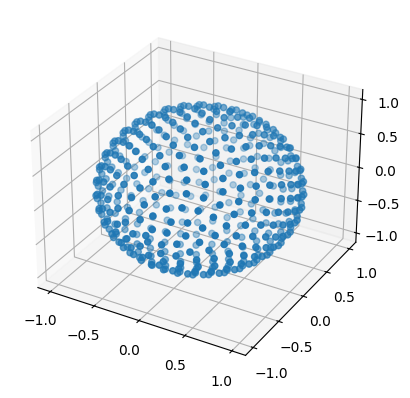

In [50]:

kugelschale= fibonacci_sphere(500)
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*kugelschale.T)
plt.show()

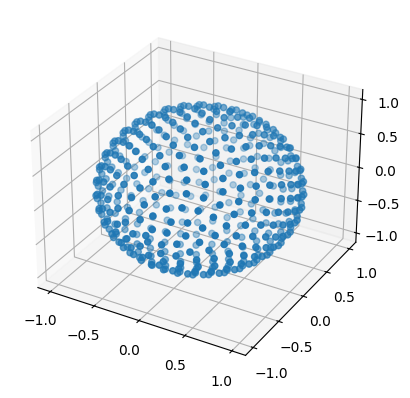

In [61]:
Kugelschale = np.divide(kugelschale, np.linalg.norm(kugelschale, axis=0))

alpha = np.arctan2(kugelschale[:,2],kugelschale[:,1])+math.pi/2
beta = np.arccos(kugelschale[:,0])

cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x_ = (cos_beta)
y_ = (sin_alpha*sin_beta)
z_ = (-cos_alpha*sin_beta)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(x_,y_,z_)
plt.show()

In [63]:
# Cache erstellen
factor = 100
range_r = 3
bands = 10
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=1)#load_dict(range_r, factor), load_dict(range_r, factor+1)

TypeError: list indices must be integers or slices, not tuple

In [79]:
# Gleichverteilte Punkte auf der Sphere samplen
def fibonacci_sphere(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))
    points = np.array(points)
    alpha = np.arctan2(points[:,2],points[:,1])+math.pi/2
    beta = np.arccos(points[:,0])
    return alpha, beta

alpha, beta = fibonacci_sphere(300)

ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)
# ODFs = get_Y_Odfs_noise(10)
np.array(ODFs).shape
np.save("Test_ODFs", ODFs[:,:,20:])

In [80]:
def kegel_from_dict_withBasis_noTranslation(dict_cache:dict, dict_cache_basis:dict, factor:int=10, alpha:np.ndarray=np.array([]), beta:np.ndarray=np.array([]), get_phi_theta = False):
    # Winkelfunktionen vordefinieren
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    koords = np.concatenate((x,y,z), axis=1)
    koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
    # Daten aus dem Dict herausholen
    arrays = [dict_cache[tuple(key)] for key in koords_rounded_int]
    result = np.array(arrays)
    arrays_basis = [dict_cache_basis[tuple(key)] for key in koords_rounded_int]
    res_basis = np.array(arrays_basis)
    # else:  # langsamer
    #     result = np.array(Parallel(n_jobs=-1)(delayed(get_array)(dict_cache,key) for key in koords_rounded_int))

    if get_phi_theta == True:
        # Phi und Theta berechnen für ODFs
        phi = np.arccos(z)
        theta = np.arctan2(y,x)
        return (result, res_basis, phi, theta)

    return result, res_basis

def reverse_rotate_and_translate_data_noTranslation(data, alpha = np.array([]), beta = np.array([])):
    # Translation Rückgängig machen
    data_ = np.copy(data)
    # Für Optimierung Variablen vor definieren
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix = np.empty((len(alpha), 3, 3))
    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    # Wende die Rotationsmatrix auf die Daten an
    result = np.matmul(rotation_matrix, data_)
    return result


def Prepare():
    result, basis, phi, theta = kegel_from_dict_withBasis_noTranslation(dict_res, dict_basis, factor, alpha, beta, True)
    result_rot = reverse_rotate_and_translate_data_noTranslation(result, alpha, beta)
    weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], 0, 0, sigma)
    return result, basis, phi, theta, result_rot, weights



def Get_AODF_noRand_noCache(ODFs:np.ndarray, result:np.ndarray, basis:np.ndarray, weights:np.ndarray, phi:np.ndarray, theta:np.ndarray,x_koord:int, y_koord:int, z_koord:int, factor_amp:int = 1000, sigma:float=2):
    # Mit weights alle punkte im Kegel ablaufen
    result_ = np.copy(result)
    result_[:,0,:] += x_koord
    result_[:,1,:] += y_koord
    result_[:,2,:] += z_koord
    AODF_Amplitude = get_amplitude(result_, ODFs, basis, weights)
    
    greater_one = np.where((AODF_Amplitude*factor_amp) > 1)[0]
    multiple_dir = np.repeat(phi[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    multiple_inc = np.pi/2 - np.repeat(theta[greater_one], np.round((AODF_Amplitude[greater_one]) * factor_amp).astype(int))
    bands = 10
    # odf3._get_bands_from_coeff(ODFs.shape[-1])
    nan_mask = ~np.isnan(multiple_inc)
    Test_mask = multiple_inc == 0
    if str(Test_mask[nan_mask].shape) == "(0,)":
        return np.empty((1,1,1,odf.get_num_coeff(bands)))
    AODF_d = odf.compute(np.ravel(multiple_dir[nan_mask]),np.ravel(multiple_inc[nan_mask]), np.ones(np.ravel(multiple_inc[nan_mask]).shape), bands)
    return AODF_d

In [81]:
import time
limit_x, limit_y, limit_z = ODFs.shape[0],ODFs.shape[1],ODFs.shape[2]
sigma = 0.1
factor_amp = 1000
bands = 10

result, basis, phi, theta = kegel_from_dict_withBasis_noTranslation(dict_res, dict_basis, factor, alpha[:,None], beta[:,None], True)
result_rot = reverse_rotate_and_translate_data_noTranslation(result, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], 0, 0, sigma)



In [82]:
start_time = time.time()
AODFs = np.array([
    Get_AODF_noRand_noCache(ODFs,result, basis, weights,phi,theta,i,j,k, sigma=sigma, factor_amp=factor_amp)
    for i in tqdm(range(range_r + 1, limit_x - range_r - 1))
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])

print("--- %s seconds ---" % (time.time() - start_time))




































































































100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:00<00:00,  7.50s/it]

--- 240.07842445373535 seconds ---


In [83]:
np.save("AODF_Stern_NoRand_goldenangle", np.reshape(AODFs,(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)))

# Passende Anzahl der Winekl nachgucken

In [6]:
import time
from main_lib import *

# Cache erstellen
factor = 100
range_r = 3
bands = 10
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=1)#load_dict(range_r, factor), load_dict(range_r, factor+1)


In [16]:

field_theta, field_phi = genereate_divergence()
ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)

limit_x, limit_y, limit_z = ODFs.shape[0],ODFs.shape[1],ODFs.shape[2] #20,20,20# 
sigma = 0.1
factor_amp = 1000
bands = 10
number = 1000
alpha, beta = fibonacci_sphere(number)

result, basis, phi, theta = kegel_from_dict_withBasis_noTranslation(dict_res, dict_basis, factor, alpha[:,None], beta[:,None], True)
result_rot = reverse_rotate_and_translate_data_noTranslation(result, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], 0, 0, sigma)


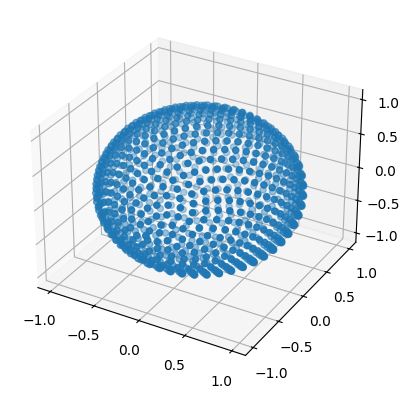

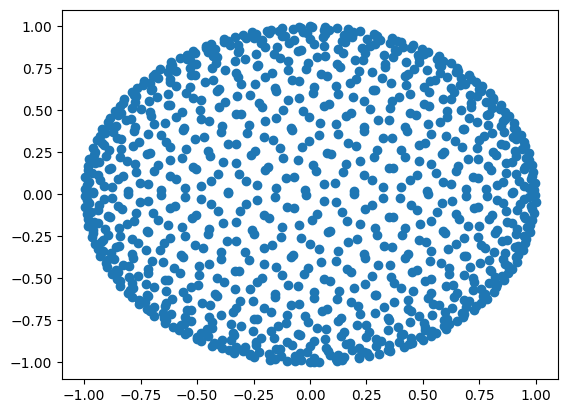

In [31]:
cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x_ = (cos_beta)
y_ = (sin_alpha*sin_beta)
z_ = (-cos_alpha*sin_beta)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(x_,y_,z_)
plt.show()

plt.scatter(x_,y_)

In [18]:
from tqdm import tqdm

AODFs = np.array([
    Get_AODF_noRand_noCache(ODFs,result, basis, weights,phi,theta,i,j,k, sigma=sigma, factor_amp=factor_amp)
    for i in tqdm(range(range_r + 1, limit_x - range_r - 1))
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])
np.save(f"AODF_Stern_NoRand_n{number}", np.reshape(AODFs,(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [08:51<00:00, 16.62s/it]


In [20]:
def fibonacci_sphere_points(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))
    points = np.array(points)
    alpha = np.arctan2(points[:,2],points[:,1])+math.pi/2
    beta = np.arccos(points[:,0])
    return points

In [22]:
kugel = fibonacci_sphere_points()
kugel.shape

(1000, 3)

In [26]:
np.unique(kugel, axis=0).shape

(1000, 3)

# Vergleich, viele Random Winkel vs wenige feste Winkel

In [57]:
from main_lib import *

field_theta, field_phi = genereate_divergence()
ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)#[15:26,15:26,15:26,:]


In [58]:
np.save("Test", ODFs)

In [56]:
import time
from main_lib import *

# Cache erstellen
factor = 100
range_r = 3
bands = 10
dict_res, dict_basis, alpha, beta = generate_dict_basis_new_noRand(range_r, factor, bands, buffer=1)#load_dict(range_r, factor), load_dict(range_r, factor+1)


field_theta, field_phi = genereate_divergence()
# ODFs = odf3.compute(field_theta[:,:,:,None], field_phi[:,:,:,None], np.ones(field_phi[:,:,:,None].shape), 10)



In [59]:

limit_x, limit_y, limit_z = ODFs.shape[0],ODFs.shape[1],ODFs.shape[2] #20,20,20# 
sigma = 0.1
factor_amp = 10
bands = 10
number = 1500
alpha, beta = fibonacci_sphere(number)

result, basis, phi, theta = kegel_from_dict_withBasis_noTranslation(dict_res, dict_basis, factor, alpha[:,None], beta[:,None], True)
result_rot = reverse_rotate_and_translate_data_noTranslation(result, alpha, beta)
weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], 0, 0, sigma)

In [60]:
from tqdm import tqdm

AODFs = np.array([
    Get_AODF_noRand_noCache(ODFs,result, basis, weights,phi,theta,i,j,k, sigma=sigma, factor_amp=factor_amp)
    for i in tqdm(range(range_r + 1, limit_x - range_r - 1))
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])
np.save(f"AODF_Stern_NoRand_n{number}_famp{factor_amp}_s{sigma}", np.reshape(AODFs,(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [16:33<00:00, 31.06s/it]


In [52]:
# Cache erstellen
range_r = 3
bands = 10

# Anzahl der Winkel festlegen
number_of_winkel = 200000
# Daten einlesen/Generieren
## Daten Generieren Y-Shape
sigma = 0.1
factor_amp = 1000

In [55]:
# AODFs = np.empty((20,20,20,odf.get_num_coeff(bands)))
# for i in range(0,20):
#     for j in range(0,20):
#         for k in range(0,1):
#             AODF_single = Get_AODF(ODFs,dict_res, dict_basis,factor,i,j,k, sigma=sigma, factor_amp=factor_amp, number_of_winkel=number_of_winkel)
#             AODFs[i,j,k,:] = AODF_single[0,0,0,:]

AODFs = np.array([
    Get_AODF(ODFs,dict_res, dict_basis,factor,i,j,k, sigma=sigma, factor_amp=factor_amp, number_of_winkel=number_of_winkel)
    for i in tqdm(range(range_r + 1, limit_x - range_r - 1))
    for j in range(range_r + 1, limit_y - range_r - 1)
    for k in range(range_r + 1, limit_z - range_r - 1)
])
np.save(f"AODF_kleiner_Stern_Rand_n{number_of_winkel}_2", np.reshape(AODFs,(limit_x - 2*(range_r + 1),limit_y - 2*(range_r + 1),limit_z - 2*(range_r + 1),121)))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:39<00:00, 53.30s/it]
